# TP 1 - Hidden Markov Models implementation

## Imports

In [84]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import itertools

## HMM Class

In [85]:
class HMM:
    def __init__(self,  nu,  Q,  theta):
        self.Q = Q
        self.nu = nu
        self.theta = theta
        self.N = len(nu)

    def forward(self,  data):
        return HMM.forward_(self.nu,  self.Q,  self.theta,  data)

    def calibrate(self,data, x0):
        def objective(params):
            nu = params[:self.N]
            Q_flat = params[self.N:self.N + self.N * self.N]
            Q = [Q_flat[self.N*k:self.N*(k+1)] for k in range(0,self.N)]
            theta = params[self.N + self.N * self.N:]
            _,llh,_ = HMM.forward_scaled(nu,Q,theta,data)
            return -llh
        Aeq = np.kron(np.eye(self.N+1),np.ones((1,self.N)))
        shp = (self.N + 1, 2 * self.N)
        Aeq = np.concatenate([Aeq, np.zeros(shp)],axis = 1)
        beq = np.ones((self.N+1))
        cons = [{"type": "eq", "fun": lambda x: (Aeq @ x).T - beq}]
        bnds = [(0, 1)] * (self.N + self.N**2) + [(None,None),(0,None)]*self.N
        res = sp.optimize.minimize(objective, x0, method='SLSQP', bounds = bnds, constraints = cons)
        nu_res = res.x[:self.N]
        Q_res_flat = res.x[self.N:self.N + self.N * self.N]
        Q_res = [Q_res_flat[self.N*k:self.N*(k+1)] for k in range(0,self.N)]
        theta_res = res.x[self.N + self.N * self.N:]
        self.nu = nu_res
        self.Q = Q_res
        self.theta = theta_res
        return self
    
    @staticmethod
    def forward_scaled(nu,  Q,  theta,  data):
        T = len(data)
        N = np.shape(Q)[0]
        B = np.array([sp.stats.norm(theta[2*k], theta[2*k+1]).pdf(data) for k in range(0,N)]).T
        B[B < 1e-7] = 1e-7
        alpha = np.zeros((T, N))
        ascale = np.zeros((T, 1))
        alpha[0,:] = nu @ B[0,:]
        ascale[0] = 1.0 / np.sum(alpha[0,:])
        for i in range(1, T):
            predicted = alpha[i-1,:] @ Q
            alpha[i,:] = predicted * B[i,:]
            ascale[i] = 1.0 /np.sum(alpha[i,:])
            alpha[i,:] *= ascale[i]
        llh = -np.sum(np.log(ascale))
        return alpha, llh, ascale

    def compute_llh( nu, Q, theta, data):
        _, llh, x = HMM.forward_scaled(nu, Q, theta, data)
        return llh

    def forward_backward(nu, Q, theta, data):
        T = len(data)
        N = np.shape(Q)[0]
        (alpha, llh, ascale) = HMM.forward_scaled(nu, Q, theta, data)
        B = np.array([sp.stats.norm(theta[2*k], theta[2*k+1]).pdf(data) for k in range(0,N)]).T
        B[B < 1e-7] = 1e-7
        beta = np.zeros((T, N))
        gamma = np.zeros((T, N))
        ksi = np.zeros((T-1, N))
        beta[-1, :] = 1
        beta[-1, :] *= ascale[-1]
        gamma[-1,:] = beta[-1,:] * alpha[-1,:] / np.sum(beta[-1,:] * alpha[-1,:], axis = 0)
        for i in range(T-2, -1, -1):
            beta[i, :] = (B[i+1,:] * beta[i+1, :]) @ np.asarray(Q).T
            beta[i, :] *= ascale[i]
            gamma[i,:] = (alpha[i,:] *  beta[i,:])/np.sum(beta[i,:] @ alpha[i,:])
        return alpha, beta, gamma, llh

    def simulate(nu, Q, theta, M):
        N = np.shape(Q)[0]
        sample = np.zeros((M, 2))
        X_traj = np.zeros((M, ), dtype=int)
        X_traj[0] = np.random.choice(range(0, N), size=(1, ), replace = True, p = nu)[0]
        for i in range(1, M):
            prev = X_traj[i-1]
            X_traj[i] = np.random.choice(range(0, N), size=(1, ), replace = True, p = Q[prev, :])[0]
        sample[:, 1] = X_traj
        for k in range(0, N):
            M_k = sample[sample[:, 1] == k].shape[0]
            sample[sample[:, 1] == k, 0] = np.random.normal(theta[2*k], theta[2*k+1], M_k)
        return sample[:, 0], X_traj

    def decode_gamma(nu, Q, theta, data):
        _, _, gamma, _ = HMM.forward_backward(nu, Q, theta, data)
        xhat = np.argmax(gamma,axis=1)
        return xhat

    def decode_viterbi(nu, Q, theta, data):
        T = len(data)
        N = np.shape(Q)[0]
        delta = np.zeros((T, N))
        psi = np.zeros((T, N),dtype=int)
        xhat = np.zeros((T, 1), dtype=int)
        log_nu = np.where(np.asarray(nu) > 0, np.log(nu), -np.inf)
        log_Q = np.where(np.asarray(Q) > 0, np.log(Q), -np.inf)
        delta[0, :] = log_nu + np.log(np.array([sp.stats.norm(theta[2*k], theta[2*k+1]).pdf(data[0]) for k in range(0,N)]).T)
        for t in range(1, T):
            scores = delta[t-1][:, None] + log_Q
            psi[t, :] = np.argmax(scores, axis=0)
            max_scores = np.max(scores, axis=0)
            delta[t, :] = max_scores + log_nu + np.log(np.array([sp.stats.norm(theta[2*k], theta[2*k+1]).pdf(data[t]) for k in range(0,N)]).T)
        xhat[-1] = np.argmax(delta[-1, :])
        for t in range(T - 2, -1, -1):
            xhat[t] = psi[t + 1, xhat[t + 1]]
        logp = delta[-1, xhat[-1]]
        return xhat.flatten()

## Simulate some mixed data

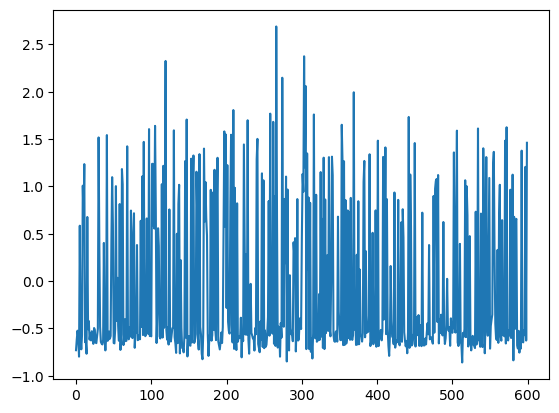

In [86]:
Y1 = np.random.normal(-0.6,0.1,400)
Y2 = np.random.normal(0.9,0.5,200)
Y = np.concatenate([Y1,Y2])
np.random.shuffle(Y)
plt.plot(Y)

## Check the forward-backward algorithm, gamma-decoding and viterbi decoding

In [87]:
nu = [0.5, 0.5]
Q = [[0.9, 0.1], [0.8, 0.2]]
theta = [0, 0.3, 0, 0.5]

In [88]:
HMM.forward_scaled(nu,Q,theta,Y)

(array([[0.17181765, 0.17181765],
        [0.70969388, 0.29030612],
        [0.80914727, 0.19085273],
        ...,
        [0.06419104, 0.93580896],
        [0.63073418, 0.36926582],
        [0.0052777 , 0.9947223 ]]),
 -1372.0286901391964,
 array([[2.91006188e+00],
        [1.50970802e+01],
        [3.20973925e+00],
        [4.72479999e+00],
        [1.63317049e+01],
        [4.38487165e+00],
        [4.65178888e+00],
        [1.00240897e+01],
        [4.03825193e+00],
        [5.89889637e+01],
        [5.26955032e+00],
        [1.89506714e+02],
        [5.73082767e+00],
        [6.02022476e+00],
        [1.32040295e+01],
        [7.43071840e+00],
        [2.96448091e+00],
        [1.99405616e+00],
        [5.47156009e+00],
        [3.66966997e+00],
        [5.69868159e+00],
        [3.31644928e+00],
        [4.17710147e+00],
        [7.06511082e+00],
        [2.78696335e+00],
        [3.10978234e+00],
        [6.54645168e+00],
        [6.68372837e+00],
        [4.44453073e+00],
     

In [89]:
HMM.forward_backward(nu, Q, theta, Y)

(array([[0.17181765, 0.17181765],
        [0.70969388, 0.29030612],
        [0.80914727, 0.19085273],
        ...,
        [0.06419104, 0.93580896],
        [0.63073418, 0.36926582],
        [0.0052777 , 0.9947223 ]]),
 array([[  7.95063147,   8.98628884],
        [ 14.76477858,  15.90943811],
        [  3.11697278,   3.60303587],
        ...,
        [142.16594476, 181.73975341],
        [  3.85135214,   7.6705293 ],
        [651.10136546, 651.10136546]]),
 array([[0.46942604, 0.53057396],
        [0.69407282, 0.30592718],
        [0.78576165, 0.21423835],
        ...,
        [0.05092526, 0.94907474],
        [0.46167692, 0.53832308],
        [0.0052777 , 0.9947223 ]]),
 -1372.0286901391964)

In [90]:
_, _, gamma, _= HMM.forward_backward(nu, Q, theta, Y)
gamma

array([[0.46942604, 0.53057396],
       [0.69407282, 0.30592718],
       [0.78576165, 0.21423835],
       ...,
       [0.05092526, 0.94907474],
       [0.46167692, 0.53832308],
       [0.0052777 , 0.9947223 ]])

## Fit the model to the data

In [91]:
x0 = [0.5, 0.5,0.8,0.2,0.1,0.9,-0.2,0.3,-1,1]
H = HMM(nu, Q, theta)
H.calibrate(Y,x0)

In [92]:
print(H.nu)
print(H.Q)
print(H.theta)

[1. 0.]
[array([0.65565929, 0.34434071]), array([0.69756523, 0.30243477])]
[-0.594       0.09682656  0.9422315   0.50849413]


Use fitted model to classify the data

In [93]:
gloc = HMM.decode_gamma(H.nu,H.Q,H.theta,Y)

In [94]:
gloc

array([1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,

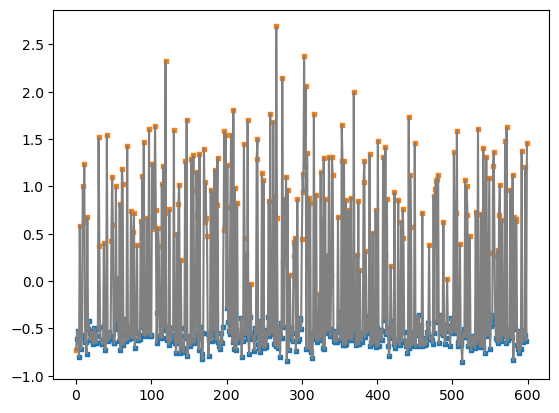

In [95]:
def plot_by_state(data,classes):    
    plt.plot(range(0,len(data)),data,color='grey')
    plt.scatter(np.where(classes==0),data[classes==0],marker = 's',s=10)
    plt.scatter(np.where(classes==1),data[classes==1],marker ='s',s=10)
    return
plot_by_state(Y,gloc)

In [96]:
gvit = HMM.decode_viterbi(H.nu,H.Q,H.theta,Y)

/var/folders/nk/kpj6413n2lj1cln9c1z0_pj80000gn/T/ipykernel_3815/1478136107.py:100: RuntimeWarning: divide by zero encountered in log
  log_nu = np.where(np.asarray(nu) > 0, np.log(nu), -np.inf)


In [97]:
gvit

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

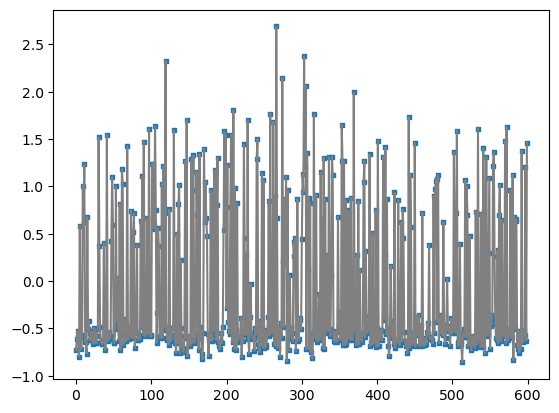

In [98]:
plot_by_state(Y,gvit)